In [ ]:
#supress warnings (especially from sklearn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, roc_curve, auc, precision_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import csv
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from scipy import interp

%matplotlib inline

<h2> Preprocessing </h2>

patient_ccs_100.csv contains the clusters (k=3) of patients after running k-modes. First, we merge the cluster information in with all the feature data. Then, we merge the readmission labels with the data to preserve the true labels. Then, we drop the CCS_codes field and the ICD9_codes fields because they are irrelevant past the clustering analysis. We then save this data to a csv file. We also drop the subject_id and hadm_id because they are also not relevant in developing models for the data. We then save this version of the data as well. 

In [ ]:
ccs_data = pd.read_csv('../data/patient_ccs_100.csv')
ccs_data = ccs_data.rename(index=str, columns={"SUBJECT_ID": "subject_id", "HADM_ID": "hadm_id"})
all_data = pd.read_csv('../data/MICU_admits_clean.csv')
labels = pd.read_csv('../data/y_more_no_df_clean.csv')
merged_data = all_data.merge(ccs_data, on=['subject_id', 'hadm_id'])
labeled_data = merged_data.join(labels)
labeled_data = labeled_data.drop(['CCS_codes', 'ICD9_CODES'], axis=1)
labeled_data.to_csv('../data/labeled_clustered_data_with_ids.csv')
save_labeled_data = labeled_data.drop(['subject_id', 'hadm_id'], axis=1)
save_labeled_data.to_csv('../data/labeled_clustered_data.csv')

<h3> Feature Analysis</h3>

For each min/mean/max feature, it compares the mean of the features in the entire data set to the means of the features per cluster

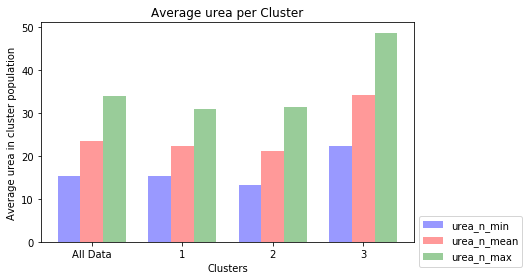

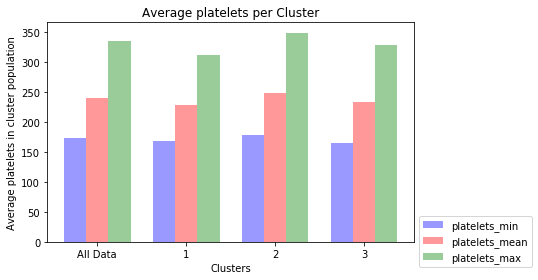

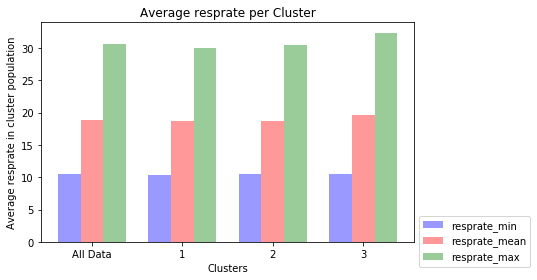

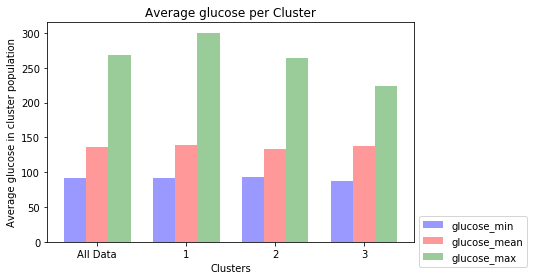

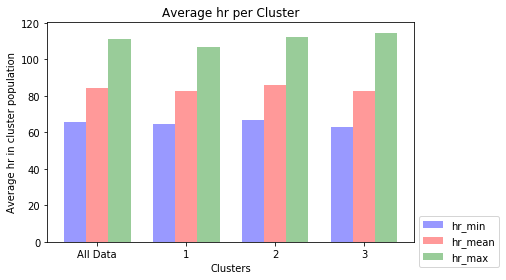

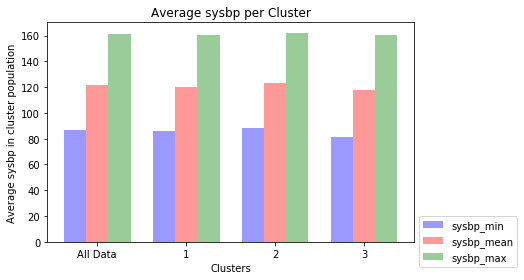

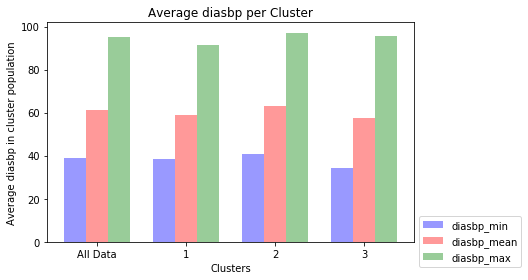

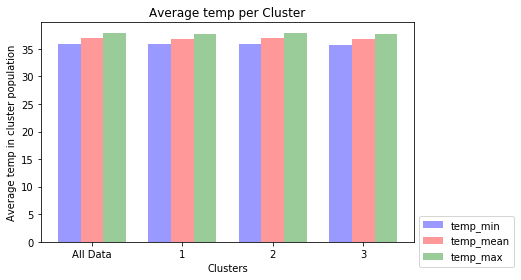

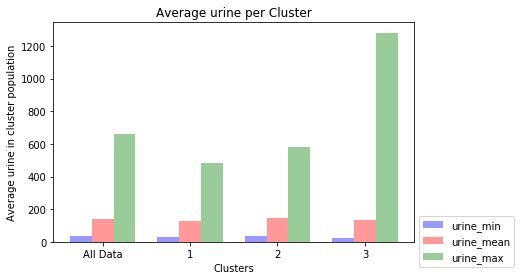

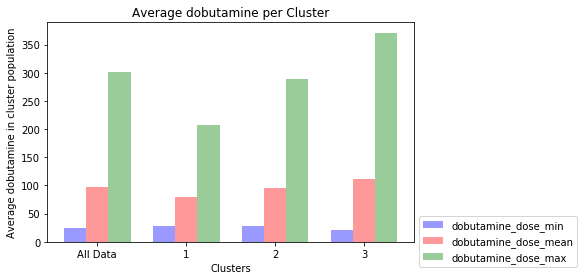

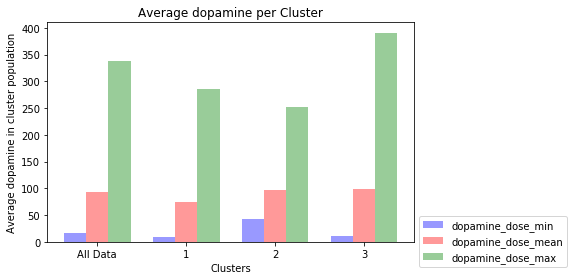

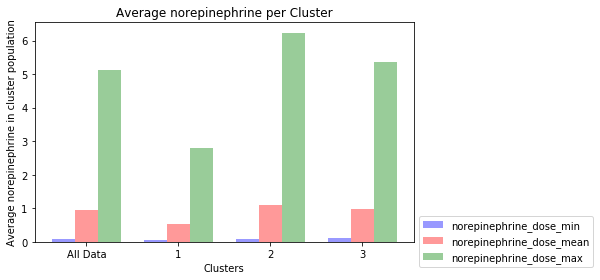

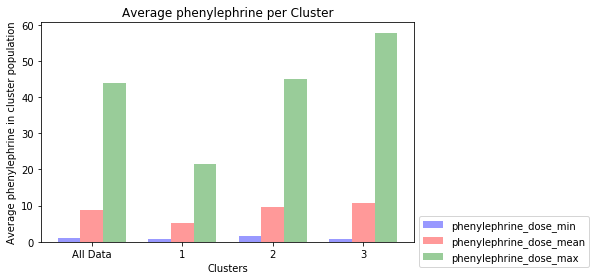

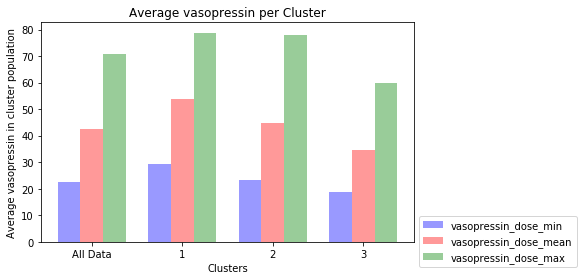

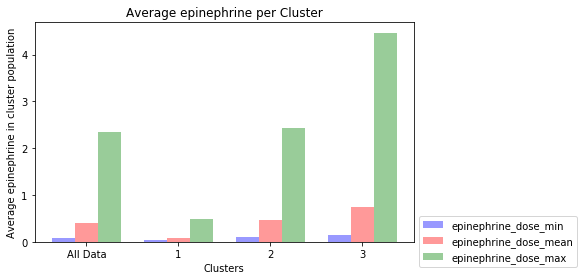

In [79]:
from os import path

features = [['urea_n_min', 'urea_n_max', 'urea_n_mean'],
            ['platelets_min', 'platelets_max', 'platelets_mean'],
            ['resprate_min', 'resprate_max', 'resprate_mean'],
            ['glucose_min', 'glucose_max', 'glucose_mean'],
            ['hr_min', 'hr_max', 'hr_mean'],
            ['sysbp_min', 'sysbp_max', 'sysbp_mean'],
            ['diasbp_min', 'diasbp_max', 'diasbp_mean'],
            ['temp_min', 'temp_max', 'temp_mean'],
            ['urine_min', 'urine_max', 'urine_mean'],
            ['dobutamine_dose_min', 'dobutamine_dose_max', 'dobutamine_dose_mean'],
            ['dopamine_dose_min', 'dopamine_dose_max', 'dopamine_dose_mean'],
            ['norepinephrine_dose_min', 'norepinephrine_dose_max','norepinephrine_dose_mean'],
            ['phenylephrine_dose_min', 'phenylephrine_dose_max', 'phenylephrine_dose_mean'],
            ['vasopressin_dose_min', 'vasopressin_dose_max', 'vasopressin_dose_mean'],
            ['epinephrine_dose_min', 'epinephrine_dose_max', 'epinephrine_dose_mean']]

cluster_readmission = labeled_data.groupby(['cluster_num']).mean()
n_groups = len(cluster_readmission) + 1

for feat_list in features:
    title = feat_list[0].split("_")[0] # get title from features

    #create list for min/mean/max and first element is mean of total data set
    feat_min = [labeled_data[feat_list[0]].mean()]
    feat_mean = [labeled_data[feat_list[2]].mean()]
    feat_max = [labeled_data[feat_list[1]].mean()]
    
    #add val per cluster
    for i in range(n_groups-1):
        feat_min.append(cluster_readmission[feat_list[0]][i])
        feat_mean.append(cluster_readmission[feat_list[2]][i])
        feat_max.append(cluster_readmission[feat_list[1]][i])
        
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.25
    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, feat_min, bar_width,
                    alpha=opacity, color='b',
                     error_kw=error_config,
                    label=feat_list[0])
    rects2 = ax.bar(index + bar_width, feat_mean, bar_width,
                    alpha=opacity, color='r',
                     error_kw=error_config,
                    label=feat_list[2])
    rects3 = ax.bar(index + 2*bar_width, feat_max, bar_width,
                    alpha=opacity, color='g',
                     error_kw=error_config,
                    label=feat_list[1])

    ax.set_xlabel('Clusters')
    ax.set_ylabel('Average ' + title + ' in cluster population')
    ax.set_title('Average ' + title + ' per Cluster')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(('All Data', '1', '2', '3'))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0))


    fig.tight_layout()
#     my_path = os.path.dirname(os.path.realpath('__file__'))
#     fig.savefig(os.path.join(my_path, "cluster_features",title + ".png"))
    plt.savefig(path.join("cluster_features",title + ".png"), bbox_inches='tight')
    plt.show()
#     plt.savefig("cluster_features/" + title + ".png")
    plt.clf()
